In [3]:
#VAE Code
import torch
import torch.nn as nn
import torch.optim as optim  # Correctly import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
from pathlib import Path
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 64x64 (or any size you want)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

class VAE(nn.Module):
    def __init__(self, latent_dim=20):  # Add latent_dim to the constructor
        super(VAE, self).__init__()
        self.latent_dim = latent_dim  # Define the latent_dim attribute
        # Define encoder and decoder networks here
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
        )
        
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        self.decoder_fc = nn.Linear(latent_dim, 512)
        self.decoder_fc2 = nn.Linear(512, 128 * 16 * 16)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 16, 16)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()  # Sigmoid to output values between 0 and 1
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = F.relu(self.decoder_fc(z))
        z = self.decoder_fc2(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(reconstructed_data, original_data, mu, logvar):
    MSE = F.mse_loss(reconstructed_data, original_data, reduction='sum')

    # KL Divergence loss (Kullback-Leibler divergence)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # The final loss is the sum of the reconstruction loss and the KL divergence
    return MSE + KL

def generate_image_from_vae(image_path):

    dataset = datasets.ImageFolder(root=image_path, transform=transform)
    batch_size = 64
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    latent_dim = 64
    vae = VAE(latent_dim=latent_dim).to(device)
    
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)

    # Training Loop
    num_epochs = 10  # You can increase this for better results

    for epoch in range(num_epochs):
        vae.train()
        train_loss = 0
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)  # Move data to device

            optimizer.zero_grad()  # Zero out gradients before backpropagation

            # Forward pass: Get the reconstructed data, mean, and log variance
            reconstructed_data, mu, logvar = vae(data)

            # Calculate the VAE loss (BCE + KL divergence)
            loss = vae_loss(reconstructed_data, data, mu, logvar)

            # Backpropagation: Compute gradients
            loss.backward()

            # Update the model's weights using the optimizer
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(data_loader.dataset)  # Calculate the average loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

    vae.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        latent_sample = torch.randn(1, vae.latent_dim).to(device)  # Random latent vector

        # Generate image from latent vector
        generated_image = vae.decode(latent_sample).cpu()  # Move back to CPU
        generated_image = generated_image.squeeze(0)  # Remove batch dimension

        # Convert image to a numpy array and display it
        generated_image = generated_image.permute(1, 2, 0).numpy()  # Change to (H, W, C)
        generated_image = (generated_image * 255).astype('uint8')  # Convert to image format
        return generated_image

Epoch [1/10], Loss: 31971.4702
Epoch [2/10], Loss: 31852.7857
Epoch [3/10], Loss: 31632.7262
Epoch [4/10], Loss: 31158.4821
Epoch [5/10], Loss: 29881.6548
Epoch [6/10], Loss: 26370.9911
Epoch [7/10], Loss: 23384.7336
Epoch [8/10], Loss: 21080.3601
Epoch [9/10], Loss: 18916.7946
Epoch [10/10], Loss: 17470.0744


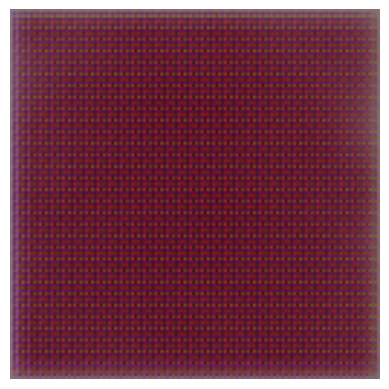

In [19]:
#Training with Amazon Red_Top_Data
generated_image_red = generate_image_from_vae('resized_red_tops_images')

# Display the generated image
plt.imshow(generated_image_red)
plt.axis('off')
plt.show()  


Epoch [1/10], Loss: 38466.9875
Epoch [2/10], Loss: 38226.6083
Epoch [3/10], Loss: 37778.6042
Epoch [4/10], Loss: 36867.8458
Epoch [5/10], Loss: 33626.3583
Epoch [6/10], Loss: 27686.0979
Epoch [7/10], Loss: 25442.6729
Epoch [8/10], Loss: 22575.4146
Epoch [9/10], Loss: 21404.6229
Epoch [10/10], Loss: 19798.9437


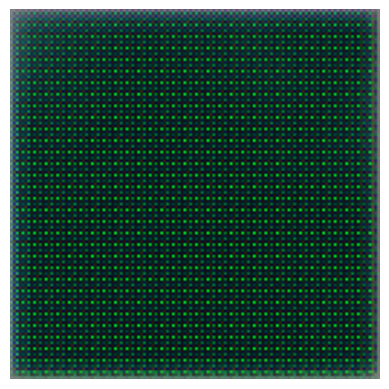

In [8]:
#Train VAE with Amazon Green_Top_Images
generated_image_green = generate_image_from_vae('Resized_green_top_images')

# Display the generated image
plt.imshow(generated_image_green)
plt.axis('off')
plt.show()  

Epoch [1/10], Loss: 30697.6625
Epoch [2/10], Loss: 30439.3969
Epoch [3/10], Loss: 28658.4938
Epoch [4/10], Loss: 617305.6000
Epoch [5/10], Loss: 21123.4250
Epoch [6/10], Loss: 19702.4750
Epoch [7/10], Loss: 17821.5906
Epoch [8/10], Loss: 16495.8609
Epoch [9/10], Loss: 15613.8297
Epoch [10/10], Loss: 15153.2547


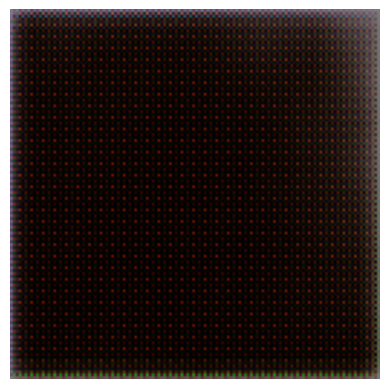

In [11]:
#Train VAE with Amazon Blue_Top_Images
generated_image_blue = generate_image_from_vae('Resized_blue_top_images')

# Display the generated image
plt.imshow(generated_image_blue)
plt.axis('off')
plt.show()  

Epoch [1/10], Loss: 28397.0969
Epoch [2/10], Loss: 28237.3344
Epoch [3/10], Loss: 27590.8063
Epoch [4/10], Loss: 27096.0531
Epoch [5/10], Loss: 25613.1250
Epoch [6/10], Loss: 21088.7891
Epoch [7/10], Loss: 25086.9672
Epoch [8/10], Loss: 15310.6719
Epoch [9/10], Loss: 13687.3828
Epoch [10/10], Loss: 12325.8211


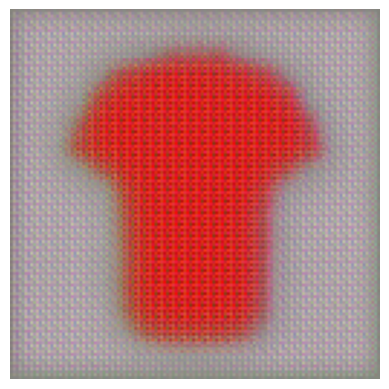

In [13]:
#Train VAE with mini_dataset of red shirts
generated_image_mini_red = generate_image_from_vae('resized_mini_dataset_images/red shirt')

# Display the generated image
plt.imshow(generated_image_mini_red)
plt.axis('off')
plt.show()

Epoch [1/10], Loss: 29920.4625
Epoch [2/10], Loss: 29724.2031
Epoch [3/10], Loss: 29289.5375
Epoch [4/10], Loss: 28094.2188
Epoch [5/10], Loss: 24119.1922
Epoch [6/10], Loss: 20087.3844
Epoch [7/10], Loss: 18671.4344
Epoch [8/10], Loss: 15697.1875
Epoch [9/10], Loss: 14414.1562
Epoch [10/10], Loss: 13925.5875


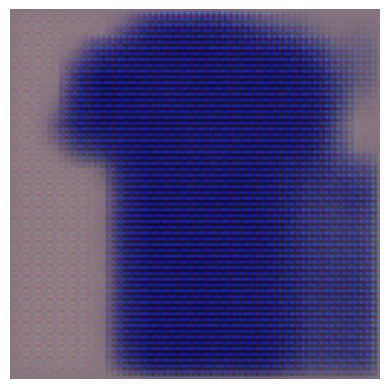

In [15]:
#Train VAE with mini_dataset of blue shirts
generated_image_mini_blue = generate_image_from_vae('resized_mini_dataset_images/blue shirt')

# Display the generated image
plt.imshow(generated_image_mini_blue)
plt.axis('off')
plt.show()

Epoch [1/10], Loss: 24165.6680
Epoch [2/10], Loss: 24016.0059
Epoch [3/10], Loss: 23738.5234
Epoch [4/10], Loss: 22731.0703
Epoch [5/10], Loss: 18340.8281
Epoch [6/10], Loss: 14856.9346
Epoch [7/10], Loss: 12901.7510
Epoch [8/10], Loss: 11714.6855
Epoch [9/10], Loss: 10897.4404
Epoch [10/10], Loss: 10217.3203


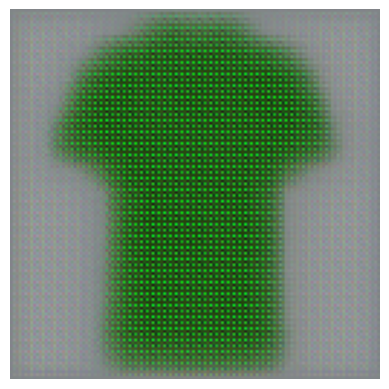

In [17]:
#Train VAE with mini_dataset of green shirts
generated_image_mini_green = generate_image_from_vae('resized_mini_dataset_images/green shirt')

# Display the generated image
plt.imshow(generated_image_mini_green)
plt.axis('off')
plt.show()